In [ ]:
# 📦 Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# 🔌 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# 🗂️ Path Configuration
TEST_DIR = '/content/drive/MyDrive/FRESHNESS_TEST_SET'  # Should contain fresh/, medium/, rotten/
MODEL_PATH = '/content/drive/MyDrive/FINAL_DATASET/models/veg_evaluatorV4.keras'
OUTPUT_CSV = '/content/drive/MyDrive/FRESHNESS_TEST_SET/misclassified_details.csv'

In [ ]:
# 🏷️ Freshness Classes (Must match training order!)
freshness_classes = ['fresh', 'medium', 'rotten']

In [ ]:
# 🧠 Load Saved Model
model = tf.keras.models.load_model(MODEL_PATH)
print("Freshness model loaded successfully!")

Freshness model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# 🖼️ Load Test Data
def load_test_data(test_dir):
    X_test, y_true, paths = [], [], []
    for class_idx, class_name in enumerate(freshness_classes):
        class_dir = os.path.join(test_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"⚠️ Missing folder for class: {class_name}")
            continue

        for img_name in tqdm(os.listdir(class_dir), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Match model input size
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X_test.append(img)
                y_true.append(class_idx)
                paths.append(img_path)

    if len(X_test) == 0:
        raise ValueError("No valid test images found!")
    return np.array(X_test)/255.0, np.array(y_true), paths

Loading rotten: 100%|██████████| 82/82 [00:52<00:00,  1.56it/s]


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

🔍 Misclassified: 145/248 (58.5%)


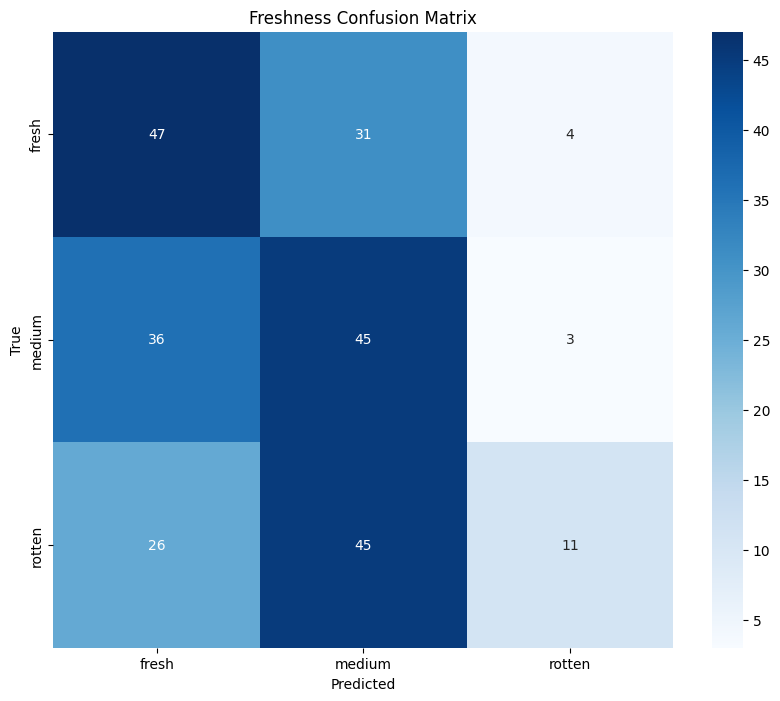


📊 Classification Report:
              precision    recall  f1-score   support

       fresh      0.431     0.573     0.492        82
      medium      0.372     0.536     0.439        84
      rotten      0.611     0.134     0.220        82

    accuracy                          0.415       248
   macro avg      0.471     0.414     0.384       248
weighted avg      0.471     0.415     0.384       248


💾 Saved misclassification report to: /content/drive/MyDrive/FRESHNESS_TEST_SET/misclassified_details.csv


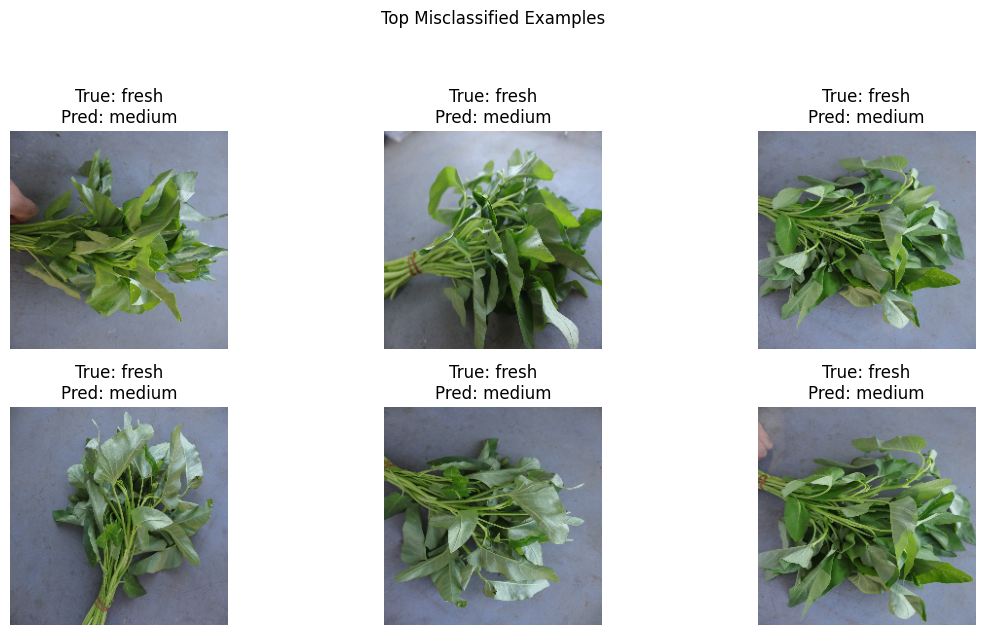

In [ ]:
# 🔍 Run Evaluation
try:
    X_test, y_true, image_paths = load_test_data(TEST_DIR)

    # Get predictions and confidence scores
    y_probs = model.predict(X_test)
    y_pred = np.argmax(y_probs, axis=1)
    confidences = np.max(y_probs, axis=1)

    # Find misclassified indices
    misclassified = np.where(y_pred != y_true)[0]

    # 📊 Generate Reports
    print(f"\n🔍 Misclassified: {len(misclassified)}/{len(X_test)} ({len(misclassified)/len(X_test):.1%})")

    # 1. Confusion Matrix
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=freshness_classes,
                yticklabels=freshness_classes)
    plt.title('Freshness Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 2. Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=freshness_classes, digits=3))

    # 3. Misclassification Analysis
    if len(misclassified) > 0:
        error_data = []
        for idx in misclassified:
            error_data.append({
                'image_path': image_paths[idx],
                'true_freshness': freshness_classes[y_true[idx]],
                'predicted_freshness': freshness_classes[y_pred[idx]],
                'confidence': confidences[idx],
                'prob_fresh': y_probs[idx][0],
                'prob_medium': y_probs[idx][1],
                'prob_rotten': y_probs[idx][2],
            })

        errors_df = pd.DataFrame(error_data)

        # Save to CSV
        errors_df.to_csv(OUTPUT_CSV, index=False)
        print(f"\n💾 Saved misclassification report to: {OUTPUT_CSV}")

        # Visualize top errors
        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(misclassified[:min(6, len(misclassified))]):
            plt.subplot(2, 3, i+1)
            plt.imshow(X_test[idx])
            plt.title(f"True: {freshness_classes[y_true[idx]]}\nPred: {freshness_classes[y_pred[idx]]}")
            plt.axis('off')
        plt.suptitle('Top Misclassified Examples', y=1.05)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"❌ Error: {str(e)}")